In [1]:
from tqdm import tqdm 
from PIL import Image 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os, random, glob

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from transformers import Dinov2Model

device = torch.device("mps")

from src.preproces_data import data_preprocess
from src.train_functions import train_epoch_twostream, validate_epoch_twostream

/Users/k.choi/opt/miniconda3/envs/pytorch_csiro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
project_dir     = "/Users/k.choi/Documents/github/csiro_git"
data_dir        = os.path.join(project_dir, "data")
models_dir      = os.path.join(project_dir, "models")
train_csv       = pd.read_csv(os.path.join(data_dir, "train.csv"))
target_names    = train_csv['target_name'].unique(); print(target_names)
primary_target  = ['Dry_Green_g', 'Dry_Total_g', 'GDM_g']   

## GDM = Dry_Clover + Dry_Green
## Dry_Total = Dry_Green + Dry_Clover + Dry_Dead

['Dry_Clover_g' 'Dry_Dead_g' 'Dry_Green_g' 'Dry_Total_g' 'GDM_g']


In [3]:
data_df = data_preprocess(train_csv, data_dir); display(data_df)

,image_path,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,0.4343,23.2239,10.5261,34.1844,10.9605
...,...,...,...,...,...,...
352,train/ID975115267.jpg,40.0300,0.0000,0.8000,40.8300,40.8300
353,train/ID978026131.jpg,24.6445,4.1948,12.0601,40.8994,36.7046
354,train/ID980538882.jpg,0.0000,1.1457,91.6543,92.8000,91.6543
355,train/ID980878870.jpg,32.3575,0.0000,2.0325,34.3900,34.3900


In [4]:
train_df ,  test_df = train_test_split(data_df, test_size=0.05, random_state=8964)
train_df ,  valid_df= train_test_split(train_df, test_size=0.2, random_state=8964)

width: 2000, height: 1000


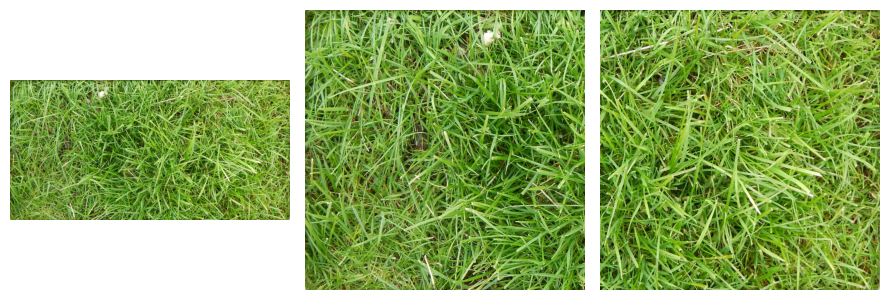

In [5]:
sample_row = train_df.iloc[0]
sample_path = sample_row['image_path']
sample_image = Image.open(os.path.join(data_dir, sample_path)).convert('RGB')

width, height = sample_image.size; print(f"width: {width}, height: {height}")

fig, axes = plt.subplots(1, 3, figsize=(9, 4))

axes[0].imshow(sample_image)

img_left  = sample_image.crop((0, 0, width//2, height))
img_right = sample_image.crop((width//2, 0, width, height))

axes[1].imshow(img_left)
axes[2].imshow(img_right)
axes[0].set_axis_off()
axes[1].set_axis_off()
axes[2].set_axis_off()

plt.tight_layout();plt.show()

In [6]:
class TwoStreamDataset(Dataset):
    def __init__(self, df, data_dir, target_names, width = 2000, height = 1000, transform=None):
        self.df = df
        self.data_dir  = data_dir
        self.transform = transform
        self.width     = width
        self.height    = height
        self.target_names = target_names


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['image_path'])
        img = Image.open(img_path).convert('RGB')

        img_left  = img.crop((0, 0, self.width//2, self.height))
        img_right = img.crop((self.width//2, 0, self.width, self.height))
        img_left = self.transform(img_left)
        img_right = self.transform(img_right)
        
        target = torch.tensor( [ row[target_name] for target_name in self.target_names ], dtype=torch.float32 )
        return img_left, img_right, target

    
def train_transform(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):

    return transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

def valid_transform(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):

    return transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])


In [7]:
batch_size  = 8
num_workers = 0

""" Dataset """

train_dataset = TwoStreamDataset(df = train_df, data_dir = data_dir, target_names = select_target, transform=train_transform())
valid_dataset = TwoStreamDataset(df = valid_df, data_dir = data_dir, target_names = select_target, transform=valid_transform())

left_sample , right_sample , target = train_dataset[0]; print(left_sample.shape, right_sample.shape, target)

""" DataLoader """

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)

for left, right, target in train_loader:
    print(left.shape, right.shape, target.shape); break

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) tensor([38.2020, 57.4741, 38.3921])
torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224]) torch.Size([8, 3])


In [ ]:
class TwoStreamDino(nn.Module):
    def __init__(self, backbone, patch_dim):
        super().__init__()

        self.backbone = backbone
        self.patch_dim = patch_dim

        for params in self.backbone.parameters():
            params.requires_grad = False
 
        self.patch_encoder = nn.Sequential(
            nn.Linear(patch_dim, 512), nn.LayerNorm(512), nn.GELU(),nn.Dropout(0.3),
            nn.Linear(512, 256), nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(256, patch_dim))

        self.fusion = nn.Sequential(
            nn.Linear(patch_dim*2, 512),nn.LayerNorm(512),nn.GELU(),nn.Dropout(0.3),
            nn.Linear(512, 256),nn.LayerNorm(256),nn.GELU(),nn.Dropout(0.3),
            nn.Linear(256, self.num_targets))
    
    def create_head(self, )

    def _process_stream(self,img):
        with torch.no_grad():
            outputs = self.backbone(img)
            patch_features = outputs.last_hidden_state[:, 1:, :] # 8, 256, 384
        b , n, d = patch_features.shape
        pred = self.mlp( patch_features.reshape(-1, d) ).reshape(b, n, -1)
        return torch.mean(pred, dim=1)

    def forward(self, left_img, right_img):
        left_features  = self._process_stream(left_img)
        right_features = self._process_stream(right_img)
        fusion_features = torch.cat([left_features, right_features], dim=1)
        return self.fusion(fusion_features)

dinov2 = Dinov2Model.from_pretrained("facebook/dinov2-small")
dinov2.eval(); dinov2.to(device)

model = TwoStreamDino(dinov2, patch_dim = 384, num_targets = len(select_target))
model.to(device)

print("params size: ", sum(p.numel() for p in model.parameters()))
print("trainable: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("frozen: ", sum(p.numel() for p in model.parameters() if not p.requires_grad))

test_left  = torch.randn(1, 3, 224, 224).to(device)
test_right = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    pred = model(test_left, test_right); 
    print("pred.shape: ", pred.shape); 
    print("test_left.shape: ", test_left.shape, "test_right.shape: ", test_right.shape)

params size:  23012611
trainable:  956035
frozen:  22056576
pred.shape:  torch.Size([1, 3])
test_left.shape:  torch.Size([1, 3, 224, 224]) test_right.shape:  torch.Size([1, 3, 224, 224])


In [9]:
NUM_EPOCHS = 50
PATIENCE = 10

LR = 1e-3
LR_PATIENCE = 0.5
LR_FACTOR = 0.5
WEIGHT_DECAY = 1e-4

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE)
criterion = nn.MSELoss()

In [10]:
history = { 'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'lr': []}

best_val = float('inf')
best_model = None

epoch_counter = 0
for epoch in range(NUM_EPOCHS): 
    print(f"\nEpoch {epoch+1} / {NUM_EPOCHS}"); print(32 * '- ')
    train_loss = 0.0
    valid_loss = 0.0

    train_loss = train_epoch_twostream(model, train_loader, optimizer, criterion, device)
    valid_loss, val_rmse, pred_list, targ_list = validate_epoch_twostream(model, valid_loader, criterion, device)
    
    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['val_rmse'].append(val_rmse)
    history['lr'].append(current_lr)
    print(f"Train_loss : {train_loss:.4f}, Valid_loss : {valid_loss:.4f}, RMSE : {val_rmse:.4f}, LR : {current_lr:.6f}")

    if valid_loss < best_val: 
        epoch_counter = 0
        print(f"Improvement from {best_val:.4f} to {valid_loss:.4f}")
        best_val, best_model = valid_loss, model.state_dict()
        torch.save(best_model, os.path.join(models_dir, "best_model_dinov2_twostream.pth")) 
    else: epoch_counter += 1; print(f"No improvement from {best_val:.4f}")
    if epoch_counter >= PATIENCE: print("Early stopping"); break
        

    


Epoch 1 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s, loss=835]    


Train_loss : 1690.9687, Valid_loss : 1388.7175, RMSE : 37.6997, LR : 0.001000
Improvement from inf to 1388.7175

Epoch 2 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s, loss=669]    


Train_loss : 1406.3563, Valid_loss : 1133.4033, RMSE : 34.0694, LR : 0.001000
Improvement from 1388.7175 to 1133.4033

Epoch 3 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s, loss=551]    


Train_loss : 1163.3549, Valid_loss : 924.1058, RMSE : 30.7577, LR : 0.001000
Improvement from 1133.4033 to 924.1058

Epoch 4 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s, loss=489]    


Train_loss : 978.4629, Valid_loss : 775.5247, RMSE : 28.1488, LR : 0.001000
Improvement from 924.1058 to 775.5247

Epoch 5 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s, loss=473]    


Train_loss : 858.0003, Valid_loss : 688.6284, RMSE : 26.4822, LR : 0.001000
Improvement from 775.5247 to 688.6284

Epoch 6 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s, loss=481]    


Train_loss : 777.8234, Valid_loss : 642.4806, RMSE : 25.5344, LR : 0.001000
Improvement from 688.6284 to 642.4806

Epoch 7 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.56it/s, loss=292]    


Train_loss : 747.9475, Valid_loss : 535.8689, RMSE : 23.4571, LR : 0.001000
Improvement from 642.4806 to 535.8689

Epoch 8 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s, loss=252]


Train_loss : 669.6363, Valid_loss : 486.7157, RMSE : 22.3723, LR : 0.001000
Improvement from 535.8689 to 486.7157

Epoch 9 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s, loss=174]


Train_loss : 598.5743, Valid_loss : 421.2664, RMSE : 20.8758, LR : 0.001000
Improvement from 486.7157 to 421.2664

Epoch 10 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s, loss=151]


Train_loss : 513.5460, Valid_loss : 369.9780, RMSE : 19.5662, LR : 0.001000
Improvement from 421.2664 to 369.9780

Epoch 11 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s, loss=164]


Train_loss : 478.5677, Valid_loss : 343.5605, RMSE : 18.8189, LR : 0.001000
Improvement from 369.9780 to 343.5605

Epoch 12 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s, loss=104]


Train_loss : 424.8127, Valid_loss : 288.7824, RMSE : 17.3100, LR : 0.001000
Improvement from 343.5605 to 288.7824

Epoch 13 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s, loss=120]


Train_loss : 400.6087, Valid_loss : 272.8415, RMSE : 16.7879, LR : 0.001000
Improvement from 288.7824 to 272.8415

Epoch 14 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s, loss=131] 


Train_loss : 362.0568, Valid_loss : 273.2167, RMSE : 16.7802, LR : 0.000500
No improvement from 272.8415

Epoch 15 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s, loss=98.6]


Train_loss : 332.8585, Valid_loss : 229.8724, RMSE : 15.4141, LR : 0.000500
Improvement from 272.8415 to 229.8724

Epoch 16 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s, loss=113] 


Train_loss : 324.2284, Valid_loss : 214.7830, RMSE : 14.8578, LR : 0.000500
Improvement from 229.8724 to 214.7830

Epoch 17 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:04<00:00,  1.87it/s, loss=116] 


Train_loss : 320.0393, Valid_loss : 206.6279, RMSE : 14.5593, LR : 0.000500
Improvement from 214.7830 to 206.6279

Epoch 18 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:04<00:00,  1.87it/s, loss=122]


Train_loss : 300.1997, Valid_loss : 205.9652, RMSE : 14.5224, LR : 0.000500
Improvement from 206.6279 to 205.9652

Epoch 19 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s, loss=92.1]


Train_loss : 299.3310, Valid_loss : 188.7060, RMSE : 13.9423, LR : 0.000500
Improvement from 205.9652 to 188.7060

Epoch 20 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s, loss=111]


Train_loss : 277.5262, Valid_loss : 185.7271, RMSE : 13.7878, LR : 0.000500
Improvement from 188.7060 to 185.7271

Epoch 21 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s, loss=113]


Train_loss : 276.5573, Valid_loss : 184.7861, RMSE : 13.7480, LR : 0.000500
Improvement from 185.7271 to 184.7861

Epoch 22 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s, loss=153] 


Train_loss : 248.3994, Valid_loss : 199.2493, RMSE : 14.2112, LR : 0.000250
No improvement from 184.7861

Epoch 23 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s, loss=128] 


Train_loss : 235.0085, Valid_loss : 174.5179, RMSE : 13.3145, LR : 0.000250
Improvement from 184.7861 to 174.5179

Epoch 24 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s, loss=127] 


Train_loss : 251.8936, Valid_loss : 177.9323, RMSE : 13.4521, LR : 0.000125
No improvement from 174.5179

Epoch 25 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.54it/s, loss=145] 


Train_loss : 234.6355, Valid_loss : 184.9066, RMSE : 13.6843, LR : 0.000063
No improvement from 174.5179

Epoch 26 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.52it/s, loss=137] 


Train_loss : 233.8258, Valid_loss : 178.9576, RMSE : 13.4699, LR : 0.000031
No improvement from 174.5179

Epoch 27 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s, loss=142] 


Train_loss : 230.4207, Valid_loss : 179.5979, RMSE : 13.4845, LR : 0.000016
No improvement from 174.5179

Epoch 28 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.52it/s, loss=139] 


Train_loss : 239.8184, Valid_loss : 178.2950, RMSE : 13.4385, LR : 0.000008
No improvement from 174.5179

Epoch 29 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s, loss=142] 


Train_loss : 235.1178, Valid_loss : 179.7062, RMSE : 13.4885, LR : 0.000004
No improvement from 174.5179

Epoch 30 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s, loss=141] 


Train_loss : 217.8721, Valid_loss : 179.3538, RMSE : 13.4759, LR : 0.000002
No improvement from 174.5179

Epoch 31 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s, loss=141] 


Train_loss : 235.4863, Valid_loss : 179.0423, RMSE : 13.4646, LR : 0.000001
No improvement from 174.5179

Epoch 32 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.56it/s, loss=141] 


Train_loss : 245.6323, Valid_loss : 179.0705, RMSE : 13.4654, LR : 0.000000
No improvement from 174.5179

Epoch 33 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s, loss=141] 

Train_loss : 237.9915, Valid_loss : 179.0688, RMSE : 13.4654, LR : 0.000000
No improvement from 174.5179
Early stopping


In [11]:
model.load_state_dict(torch.load(os.path.join(models_dir, "best_model_dinov2_twostream.pth")))
model.eval()
test_dataset = TwoStreamDataset(df = test_df, data_dir = data_dir, target_names = select_target, transform=valid_transform())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)

In [12]:
pred_list , targ_list = [], []
with torch.no_grad():
    pbar = tqdm(test_loader, desc='Test_Datasets')
    for left, right, target in pbar:
        left = left.to(device); right = right.to(device); target = target.to(device)
        pred = model(left, right)
        pred_list.append(pred.cpu())
        targ_list.append(target.cpu())

pred_list = torch.cat(pred_list, dim=0).numpy()
targ_list = torch.cat(targ_list, dim=0).numpy()

Test_Datasets: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


In [26]:
metric_data = []


for i , tar in enumerate(select_target):
    y_true, y_pred = targ_list[:,i], pred_list[:,i]
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    metric_data.append({ 'target': tar, 'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2})

metric_data.append({
    'target' : 'overall', 
    'mae': mean_absolute_error(targ_list.flatten(), pred_list.flatten()), 
    'mse': mean_squared_error(targ_list.flatten(), pred_list.flatten()), 
    'rmse': np.sqrt(mean_squared_error(targ_list.flatten(), pred_list.flatten())), 
    'r2': r2_score(targ_list.flatten(), pred_list.flatten())})

metric_df = pd.DataFrame(metric_data)
display(metric_df)



,target,mae,mse,rmse,r2
0,Dry_Green_g,5.831068,66.351906,8.145668,0.799477
1,Dry_Total_g,15.685554,676.710999,26.013669,0.362140
2,GDM_g,5.854784,51.387589,7.168514,0.837990
3,overall,9.123802,264.816833,16.273194,0.618119


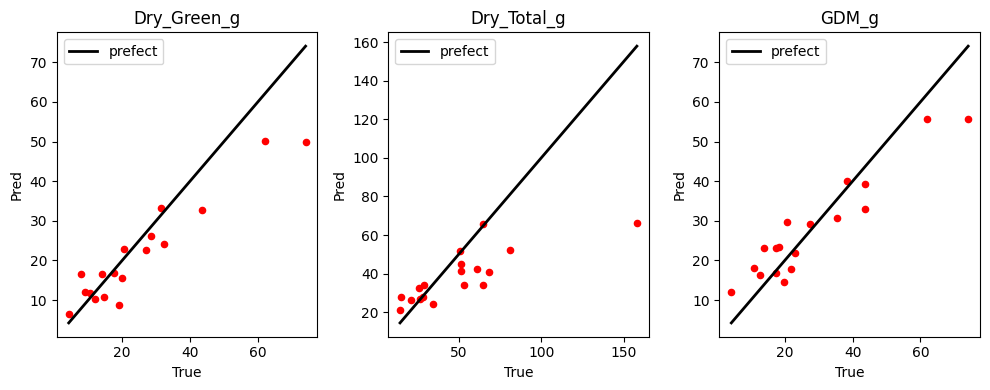

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i , tar in enumerate(select_target):
    y_true, y_pred = targ_list[:,i], pred_list[:,i]
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axes[i].scatter(y_true, y_pred, alpha=1, c='r', s= 20)
    axes[i].set_xlabel('True')
    axes[i].set_ylabel('Pred')
    axes[i].set_title(f'{tar}')
    axes[i].plot([min_val, max_val], [min_val, max_val], c='k', lw=2, label = 'prefect')
    axes[i].legend()
plt.tight_layout(); plt.show()

In [28]:
constrain1 = row0['Dry_Green_g'] + row0['Dry_Clover_g'] + row0['Dry_Dead_g'] - row0['Dry_Total_g']; print(f"{constrain1:.3f}")
constrain2 = row0['GDM_g'] - row0['Dry_Green_g'] - row0['Dry_Clover_g']; print(f"{constrain2:.3f}")

0.000
-0.000


In [37]:
no_clovert = train_df[train_df['Dry_Clover_g'] < 0.001]

for idx in range(len(no_clovert)):
    print(f"idx: {idx}", 10 * ' -')
    row = no_clovert.iloc[idx]
    constrain1 = row['Dry_Green_g'] + row['Dry_Clover_g'] + row['Dry_Dead_g'] - row['Dry_Total_g']; print(f"constrain1: {constrain1:.3f}")
    constrain2 = row['GDM_g'] - row['Dry_Green_g'] - row['Dry_Clover_g']; print(f"constrain2: {constrain2:.3f}")
    print(row['GDM_g'] , row['Dry_Green_g'])
    if idx > 10: break

idx: 0  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
58.2 58.2
idx: 1  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
30.4615 30.4615
idx: 2  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
34.0699 34.0699
idx: 3  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
104.1503 104.1503
idx: 4  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
19.8538 19.8538
idx: 5  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
22.1235 22.1235
idx: 6  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
28.9181 28.9181
idx: 7  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
6.8 6.8
idx: 8  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
24.2376 24.2376
idx: 9  - - - - - - - - - -
constrain1: 0.000
constrain2: 0.000
60.0887 60.0887
idx: 10  - - - - - - - - - -
constrain1: -0.000
constrain2: 0.000
103.6236 103.6236
idx: 11  - - - - - - - - - -
constrain1: -0.000
constrain2: 0.000
39.1446 39.1446


NameError: name 'sel_target' is not defined

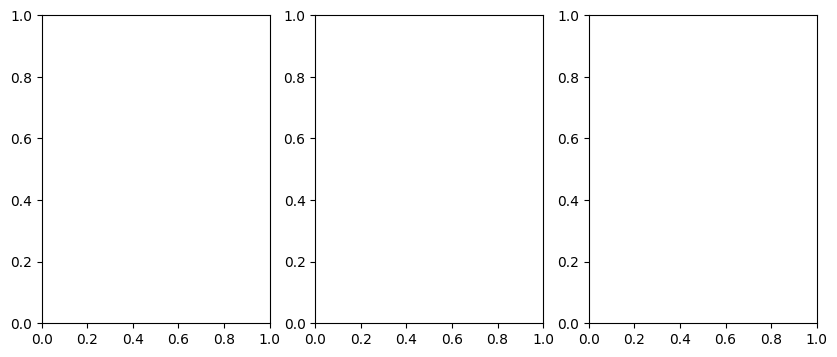

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i , tar in enumerate(sel_target):
    y_true, y_pred = targ_list[:,i], pred_list[:,i]
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axes[i].scatter(y_true, y_pred, alpha=1, c='r', s= 20)
    axes[i].set_xlabel('True')
    axes[i].set_ylabel('Pred')
    axes[i].set_title(f'{tar}')
    axes[i].plot([min_val, max_val], [min_val, max_val], c='k--', lw=2, label = 'prefect')
    axes[i].legend()
plt.tight_layout(); plt.show()